In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0


In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 4s 133us/step


'C:\\Users\\Administrator\\.keras\\datasets\\auto-mpg.data'

In [22]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration','Model Year','Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                         na_values="?", comment='\t',
                         sep=" ",skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [23]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [24]:
dataset = dataset.dropna(axis=0)

In [21]:
origin = dataset.pop('Origin')

KeyError: 'Origin'

In [25]:
origin

0      1
1      1
2      1
3      1
4      1
      ..
393    1
394    2
395    1
396    1
397    1
Name: Origin, Length: 392, dtype: int64

In [26]:
dataset['USA'] = (origin==1)*1.0
dataset['Europe'] = (origin==2)*1.0
dataset['Japan'] = (origin==3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,2,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,1.0,0.0,0.0


In [27]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

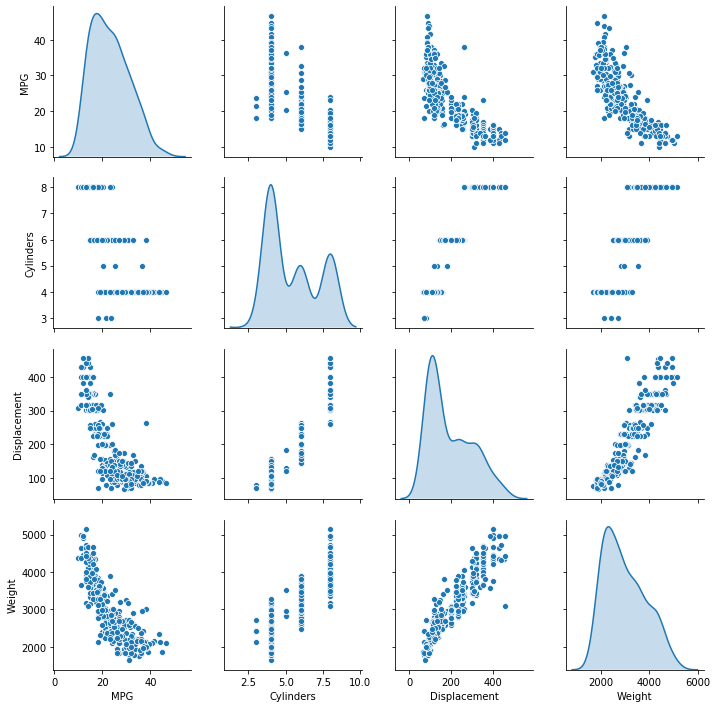

In [29]:
sns.pairplot(train_dataset[['MPG','Cylinders','Displacement','Weight']], diag_kind='kde')

In [31]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Origin,314.0,1.573248,0.800988,1.0,1.00,1.0,2.00,3.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [32]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [33]:
def norm(x):
    return (x-train_stats['mean'])/train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [41]:
train_dataset.keys()

Index(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
       'Model Year', 'Origin', 'USA', 'Europe', 'Japan'],
      dtype='object')

## 构建模型

In [37]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae','mse'])
    return model


In [38]:
model = build_model()

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                704       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
_________________________________________________________________


In [48]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 1.1411257e-01],
       [ 2.3237411e-02],
       [ 1.3311207e-04],
       [-4.7902130e-03],
       [ 1.8851019e-01],
       [ 1.2549698e-01],
       [ 1.9796519e-01],
       [ 3.8877851e-01],
       [ 1.6040103e-01],
       [ 3.4436616e-01]], dtype=float32)

In [51]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch%100==0:
            print(" ")
        print(".",end='')
        
EPOCHS = 1000

history = model.fit(normed_train_data,
                   train_labels,
                   epochs=EPOCHS,
                   validation_split = 0.2,
                   verbose=0,
                   callbacks=[PrintDot()])

 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
.................................................................................................... 
................................................................................

In [52]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.451247,0.983012,2.451247,10.369421,2.402996,10.369422,995
996,2.234190,0.967718,2.234190,9.397484,2.229117,9.397484,996
997,2.357243,0.993375,2.357243,9.240446,2.218313,9.240446,997
998,2.338631,0.996431,2.338631,9.735622,2.272604,9.735622,998
999,2.439396,1.024595,2.439396,9.710628,2.321506,9.710629,999


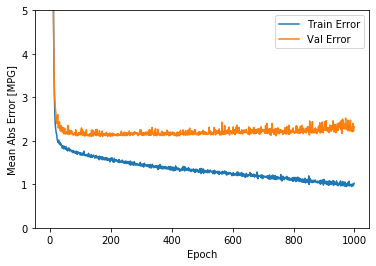

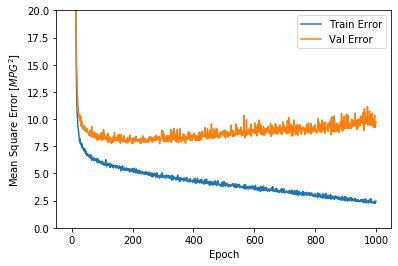

In [54]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'],hist['mae'],label='Train Error')
    plt.plot(hist['epoch'],hist['val_mae'],label='Val Error')
    plt.ylim([0,5])
    plt.legend()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'],hist['mse'],label='Train Error')
    plt.plot(hist['epoch'],hist['val_mse'],label='Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()
    
plot_history(history)

### 发现100个epoch后误差非但没有改进，反而出现恶化，所以我们需要 *回调*

 
............................................

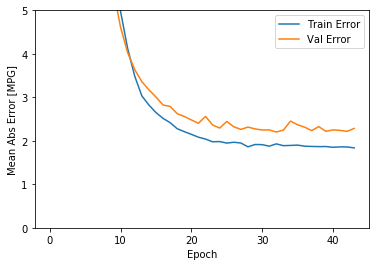

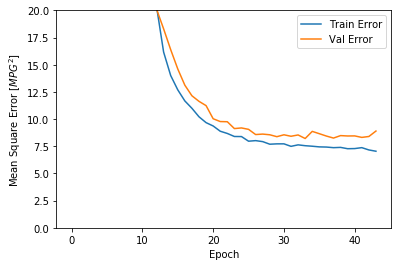

In [66]:
model = build_model()

# patience用来检查改进 epochs 的数量
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                   validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])
plot_history(history)

### 使用测试集评估

In [67]:
loss, mae,  mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 5.7788 - mae: 1.8460 - mse: 5.7788
Testing set Mean Abs Error:  1.85 MPG


### 预测结果

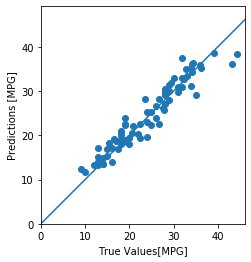

In [71]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel("True Values[MPG]")
plt.ylabel("Predictions [MPG]")
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100,100],[-100,100])

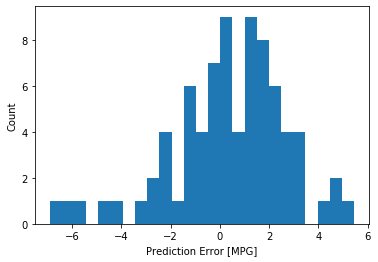

In [69]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel("Count")